In [1]:
%load_ext autoreload
%autoreload 2 

## Solving the Ising model with TEBD (time-evolving block decimation)
### (0) Derivation of the transfer matrix of the 1D classical Ising model

1D spin chain:

<img src="Ising_1D.png" alt="Caption" width="300"/>

source: Paolasini magnetism lecture 7

The Hamiltonian of the classical 1D Ising model with $N$ spins is given by  
$$H = -J \sum_{<i,j>} \sigma_i \sigma_j,$$
where $\sigma_i$ are classical spins that can take values $+1$ and $-1$, $J$ is the coupling constant between neighboring spins. 
The partition function of this system is 
$$Z = \text{Tr} ( e^{-\beta H}) = \sum_{\{ \sigma \} } \prod_{<i,j>} e^{J\beta \sigma_i \sigma_j},$$
with the inverse temperature $\beta= 1/k_BT$. The sum is over all possible microstates of the spin chain. 
We define the so-called transfer matrix in the space of two neighboring spins as
$$T =  \begin{pmatrix} e^{J\beta} & e^{-J\beta} \\ e^{-J\beta} & e^{J\beta} \end{pmatrix} ,$$
such that the partition function simply reduces to a matrix multiplication problem: 
$$Z = \text{Tr} ( T^N) .$$

### (1) Expressing the partition function of the 2D classical Ising model as a tensor network

Now we study the 2D Ising model on a square lattice:

<img src="Ising_2D.png" alt="Caption" width="300"/>

source: Paolasini magnetism lecture 7

Each spin has $4$ nearest neighbors: top, left, bottom, right. For a single bond we can recycle the transfer matrix $T$ from the 1D Ising model. It will be advantageous to factorize this matrix as follows
$$T_{\sigma_i,\sigma_j} = \sum_{\sigma_k} W_{\sigma_i, \sigma_k} W_{\sigma_j, \sigma_k},$$
with the matrix $W$ given by 
$$W =  \begin{pmatrix} \sqrt{\cosh J\beta} & \sqrt{\sinh J \beta } \\ \sqrt{\cosh J\beta} & -\sqrt{\sinh J \beta } \end{pmatrix}.$$
From this, a local tensor at each site $i$ can be constructed as
$$A_{u_i,d_i,l_i,r_i}^{i} = \sum_{\sigma_i} W_{\sigma_i, u_i}W_{\sigma_i, d_i}W_{\sigma_i, l_i}W_{\sigma_i, r_i}.$$
I think this is easiest understood from the following graphic: 

<img src="site_tensor.png" alt="Caption" width="500"/>

source: Zhao et. al., PRB 93, 125115 (2016)

#### (2) Using TEBD to contract the tensor network 

If we rotate the lattice by $45^°$, it becomes clear that we can use the TEBD algorithm to perform the contraction of the tensor network.

<img src="TEBD.png" alt="Caption" width="800"/>

source: Pollmann https://arxiv.org/pdf/1805.00055

In [2]:
import sys
sys.path.append('/Users/mina-lou/Desktop/Frank')
import isingtebd 
import matplotlib.pyplot as plt 
import numpy as np

In [46]:
# define some parameters 

J=1             # interaction strength
chi_m=100       # maximum virtual bond dimension 
eps=1e-10       # cutoff for singular values of 2-site wavefunction \Theta
Nx=40           # number of sites in x
N_steps = 20    # number of update steps / 2 in y 

betas = np.arange(0.1,5.1,0.2)      # temperature range 


In [47]:
# measure magnetisation for different values of beta 
mags = isingtebd.get_mag_curve(Nx,betas,J,N_steps,chi_m,eps) 

step =  0 bond=  0
chiv crit=  2
norm lambda 1.0
norm squared=  41.0
step =  0 bond=  2
chiv crit=  2
norm lambda 1.0
norm squared=  42.0
step =  0 bond=  4
chiv crit=  2
norm lambda 1.0
norm squared=  43.0
step =  0 bond=  6
chiv crit=  2
norm lambda 1.0
norm squared=  44.0
step =  0 bond=  8
chiv crit=  2
norm lambda 1.0
norm squared=  45.0
step =  0 bond=  10
chiv crit=  2
norm lambda 1.0
norm squared=  46.0
step =  0 bond=  12
chiv crit=  2
norm lambda 1.0
norm squared=  47.0
step =  0 bond=  14
chiv crit=  2
norm lambda 1.0
norm squared=  48.00000000000001
step =  0 bond=  16
chiv crit=  2
norm lambda 1.0
norm squared=  49.000000000000014
step =  0 bond=  18
chiv crit=  2
norm lambda 1.0
norm squared=  50.000000000000014
step =  0 bond=  20
chiv crit=  2
norm lambda 1.0
norm squared=  51.000000000000014
step =  0 bond=  22
chiv crit=  2
norm lambda 1.0
norm squared=  52.000000000000014
step =  0 bond=  24
chiv crit=  2
norm lambda 1.0
norm squared=  53.000000000000014
step =  0 bo

In [35]:
print(mags) 

[np.float64(0.9835529677102388), np.float64(0.8578745676338254)]


In [ ]:
#np.save("data/mag_curve_J=1_chi=100_eps=1e-20_Nx=20_steps=10_A", mags)
#np.save("data/betas_A", betas) 
mags = np.load("/Users/mina-lou/Desktop/Frank/isingtebd/results/data/mag_curve_J=1_chi=100_eps=1e-20_Nx=20_steps=10_A.npy")
betas = np.load("/Users/mina-lou/Desktop/Frank/isingtebd/results/data/betas_A.npy") 

Text(0, 0.5, 'magnetisation')

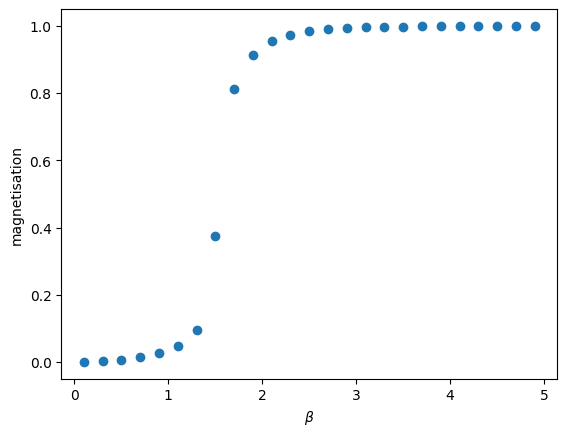

In [48]:
#plot results

plt.scatter(betas,mags)   
plt.xlabel(r"$\beta$")
plt.ylabel("magnetisation") 
#plt.xlim(0,3) 


#### (3) using iTEBD, periodic boundary conditions

In [ ]:
J=1             # interaction strength
chi_m=100       # maximum virtual bond dimension 
eps=1e-10       # cutoff for singular values of 2-site wavefunction \Theta, keep around 1e-10
Nx=40           # number of sites in x
N_steps = 20    # number of update steps / 2 in y 

betas2 = [0.5,1.0,1.5,2.0,3.0, 3.5, 4.0, 5.0] 
mags_inf = isingtebd.get_mag_curve(Nx,betas2,J,N_steps,chi_m,eps,"infinite")

step =  0 bond=  0
chiv crit=  2
norm lambda 1.0
norm squared=  41.0
step =  0 bond=  2
chiv crit=  2
norm lambda 1.0
norm squared=  42.0
step =  0 bond=  4
chiv crit=  2
norm lambda 1.0
norm squared=  43.0
step =  0 bond=  6
chiv crit=  2
norm lambda 1.0
norm squared=  44.0
step =  0 bond=  8
chiv crit=  2
norm lambda 1.0
norm squared=  45.0
step =  0 bond=  10
chiv crit=  2
norm lambda 1.0
norm squared=  46.0
step =  0 bond=  12
chiv crit=  2
norm lambda 1.0
norm squared=  47.0
step =  0 bond=  14
chiv crit=  2
norm lambda 1.0
norm squared=  48.00000000000001
step =  0 bond=  16
chiv crit=  2
norm lambda 1.0
norm squared=  49.000000000000014
step =  0 bond=  18
chiv crit=  2
norm lambda 1.0
norm squared=  50.000000000000014
step =  0 bond=  20
chiv crit=  2
norm lambda 1.0
norm squared=  51.000000000000014
step =  0 bond=  22
chiv crit=  2
norm lambda 1.0
norm squared=  52.000000000000014
step =  0 bond=  24
chiv crit=  2
norm lambda 1.0
norm squared=  53.000000000000014
step =  0 bo

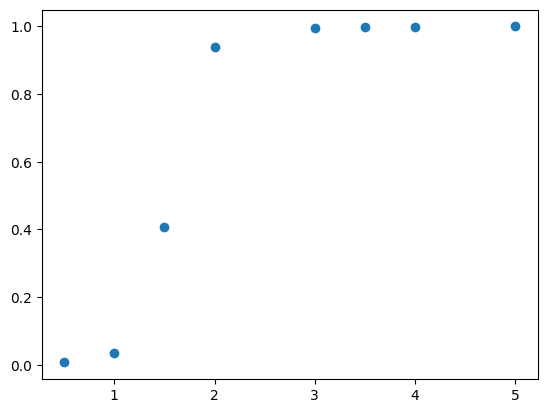

In [50]:
plt.scatter(betas2, mags_inf)  